In [74]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [75]:
from pathlib import Path

In [76]:
from tensorflow import keras

In [77]:
DATA_DIR = Path("dataset")

EPOCHS = 20
BATCHES = 32
IMAGE_SIZE = 256
CHANNEL = 3

In [78]:
data = keras.utils.image_dataset_from_directory(DATA_DIR)

Found 16011 files belonging to 10 classes.


In [79]:
class_names = data.class_names
class_names

['bacterial spot',
 'early blight',
 'healthy',
 'late blight',
 'leaf mold',
 'mosaic virus',
 'septoria leaf spot',
 'target spot',
 'two spotted spider mite',
 'yellowLeaf curl virus']

In [80]:
no_of_classes = len(class_names)
no_of_classes

10

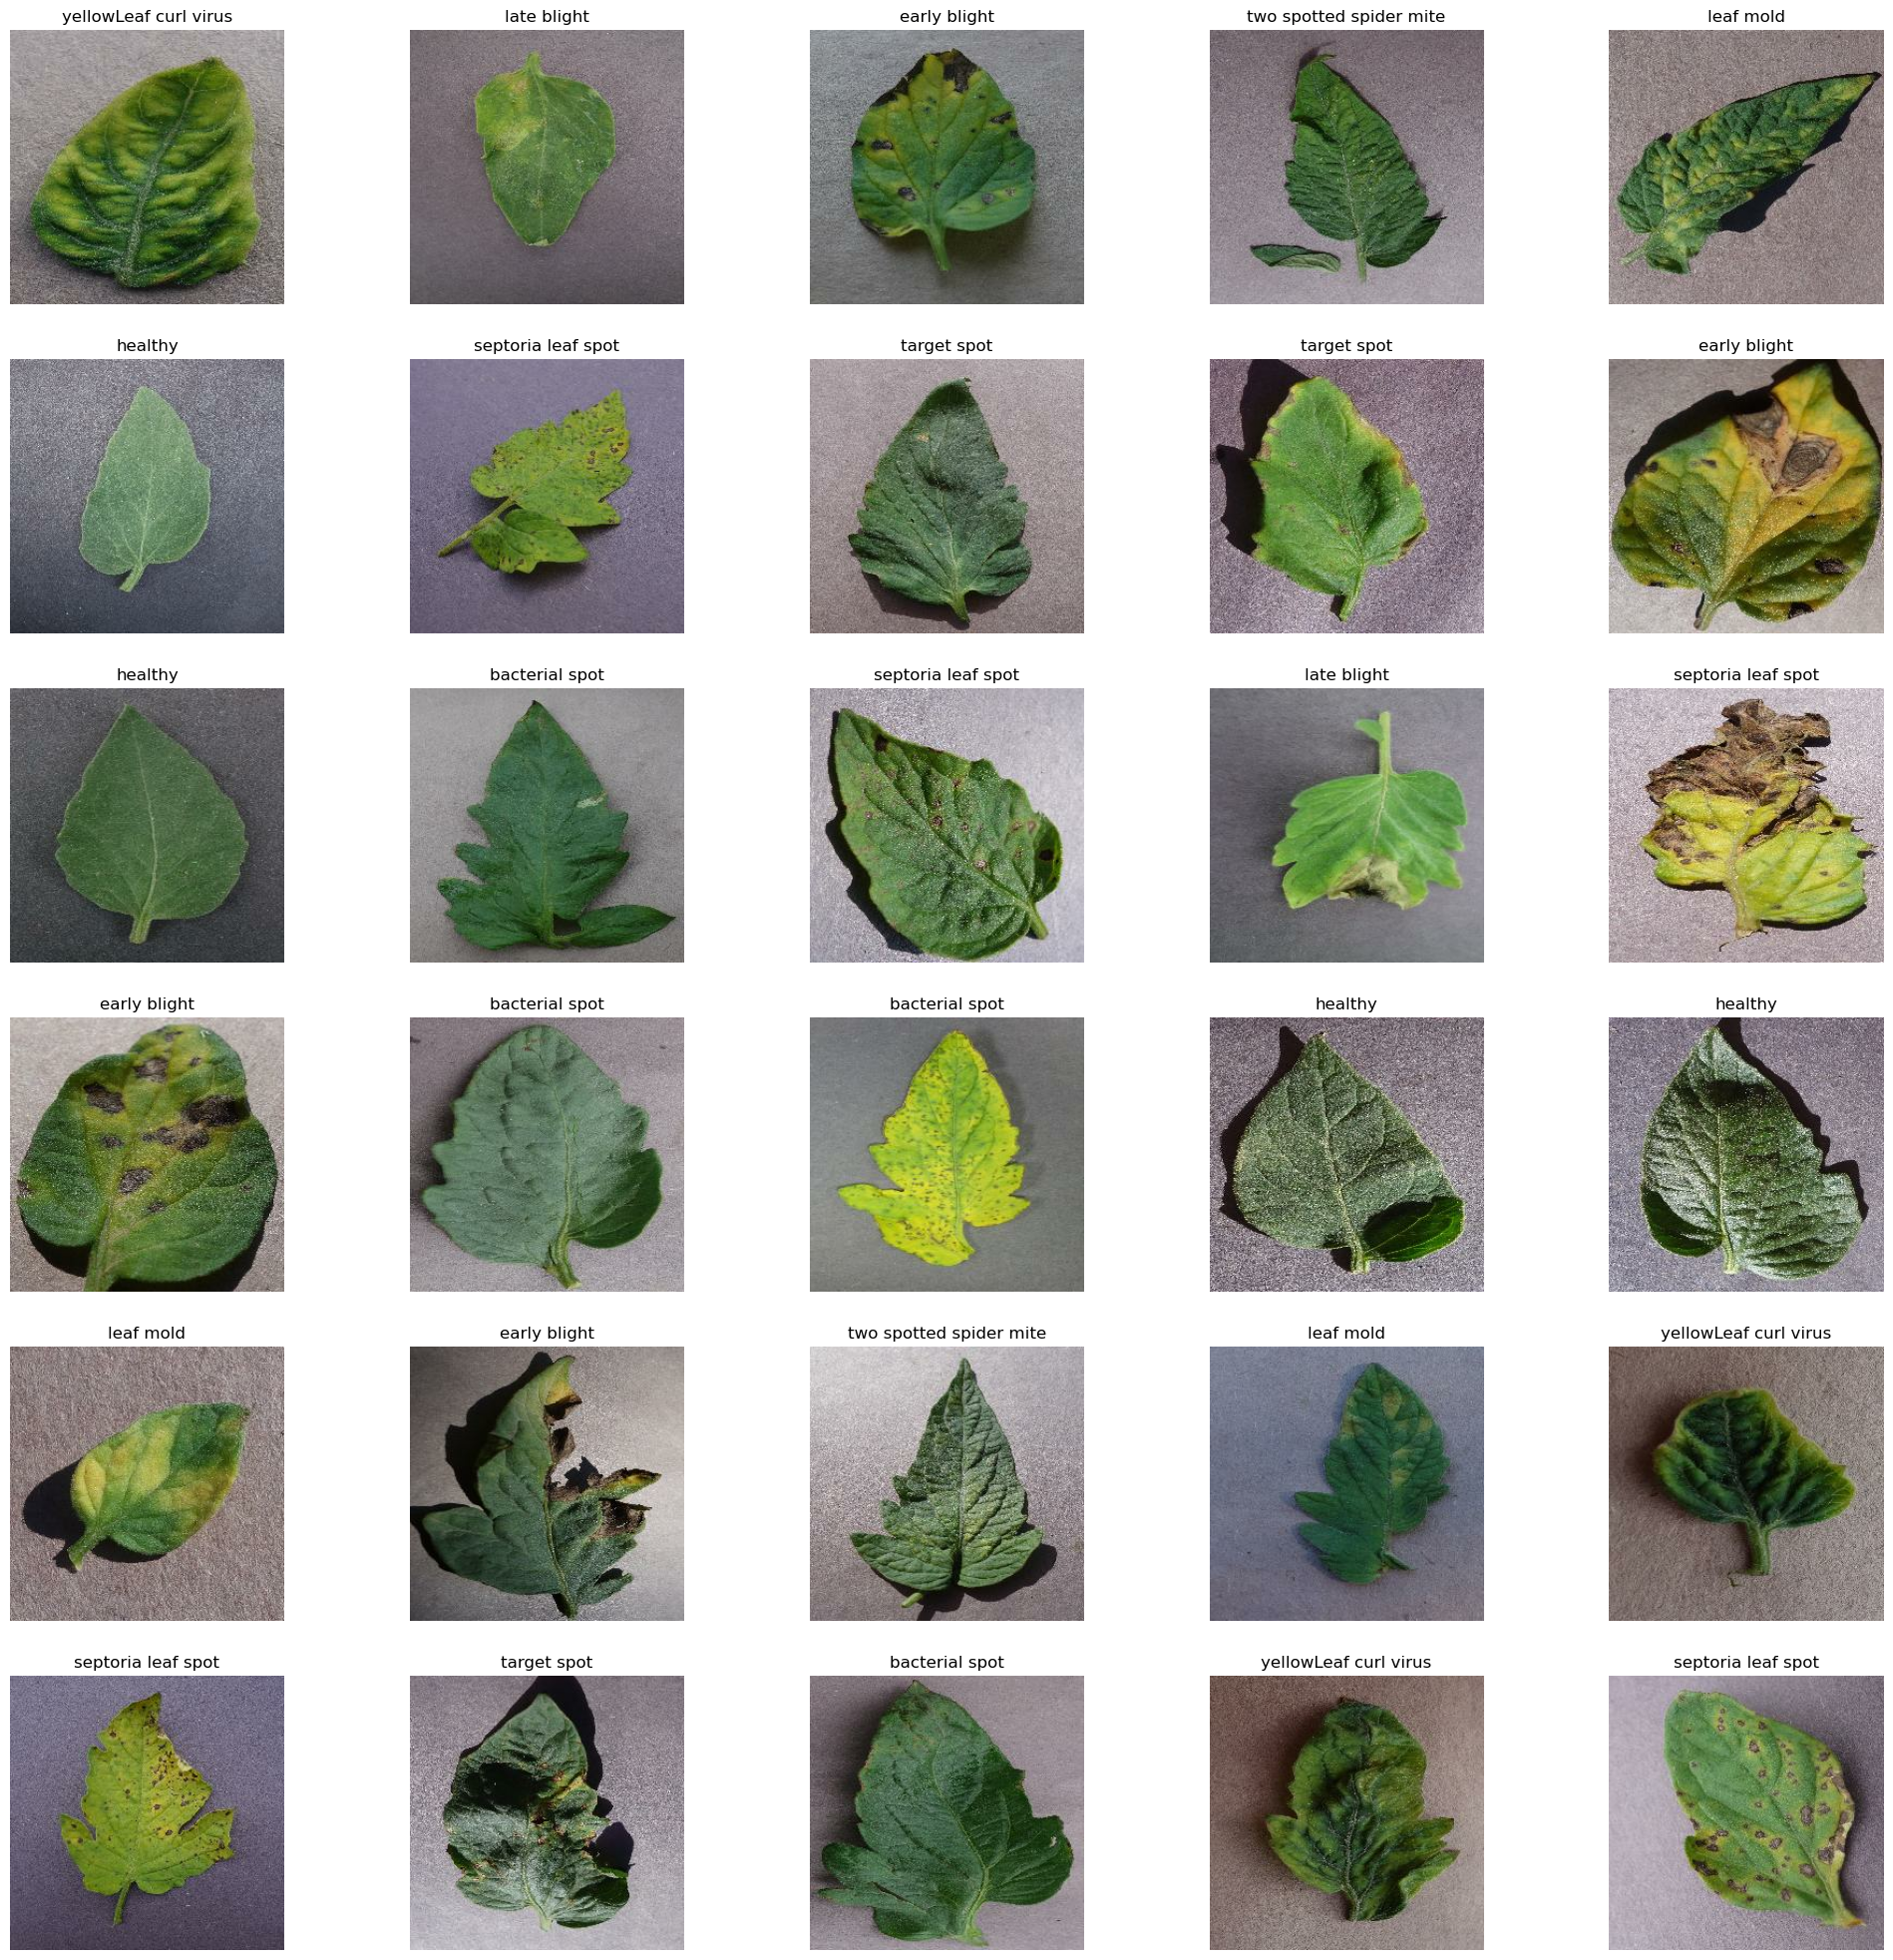

In [81]:
plt.figure(figsize=(25, 25))

for images, classes in data.take(1):
    for i in range(30):
        plt.subplot(6, 5, i + 1)
        plt.imshow(images[i].numpy().astype(int))
        plt.axis("off")
        plt.title(class_names[classes[i]])

In [82]:
def train_test_val_split(dataset, test_split=0.2, val_split=0.1, shuffle=True, shuffle_size=1000):
    ds_size = len(dataset)
    
    if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed=45)
    
    test_size = int(ds_size * test_split)
    val_size = int(ds_size * val_split)
    
    ds_test = dataset.take(test_size)
    ds_val = dataset.skip(test_size).take(val_size)
    ds_train = dataset.skip(test_size).skip(val_size)
    
    return ds_train, ds_test, ds_val

In [83]:
ds_train, ds_test, ds_val = train_test_val_split(data)

In [84]:
# data resizing

resize_and_rescale = keras.models.Sequential()

resize_and_rescale.add(keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE))
resize_and_rescale.add(keras.layers.Rescaling(scale = 1./255))

In [85]:
# creating augmented data for training

aug_data = keras.models.Sequential()

aug_data.add(keras.layers.RandomFlip())
aug_data.add(keras.layers.RandomRotation(0.2))

In [86]:
ds_aug = ds_train.map(lambda x, y: (aug_data(x, training=True), y))

In [87]:
ds_train = ds_train.concatenate(ds_aug)

In [88]:
#model building

model = keras.models.Sequential()

model.add(resize_and_rescale)
model.add(keras.layers.Conv2D(64, 3, 1, activation="relu"))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.Conv2D(32, 3, 1, activation="relu"))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.Conv2D(32, 3, 1, activation="relu"))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(64, activation="relu"))
model.add(keras.layers.Dense(no_of_classes, activation="softmax"))

In [89]:
INPUT_SHAPE = (BATCHES, IMAGE_SIZE, IMAGE_SIZE, CHANNEL)
model.build(input_shape = INPUT_SHAPE)

In [90]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_7 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_4 (Conv2D)           (32, 254, 254, 64)        1792      
                                                                 
 max_pooling2d_4 (MaxPoolin  (32, 127, 127, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (32, 125, 125, 32)        18464     
                                                                 
 max_pooling2d_5 (MaxPoolin  (32, 62, 62, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (32, 60, 60, 32)         